In [79]:
#meta 2/2/2021 Poker my Model multi algos 
#Previously in 1-model kNN, transformed dataset from Kaggle and got to decent accuracy ~78%.
#data: transformed dataset from Kaggle (800K records x 54 features)
#input: data/my_poker_tidy.pkl
#output: n/a
#based on tryPoker_1_model_clf_kNN.ipynb

#history
#based on tryPoker_1_model_clf_kNN.ipynb

#2/2/202 MODELING WITH MULTI ALGOS, WITH TRANSFORMED KAGGLE DS
#      Kaggle ds, transformed into numpy matrix 800K x 54
#      note: train/test split is not stratified
#      Try diff algos
#      note: neither algo is fine-tuned

#here 2/2/202 MODEL KERAS NN, DIFF LAYERS, WITH TRANSFORMED KAGGLE DS
#      Great accuracy, over 99% but not good at detecting minority classes; 
#      note: still no proper train, valid and test ds


In [80]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
from os import path
import time #to track performance time
import warnings
warnings.filterwarnings('ignore')

#modeling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

#modeling help
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from joblib import load, dump

# Poker Example with Keras
After transforming the raw data into nx53 representation, try different algos: LogR, CART, SVM, Keras NN and kNN modeling. Compare results.

## 0. Load Data

In [81]:
poker = load('data/my_poker_tidy.pkl')
poker.shape

(800000, 53)

In [82]:
poker['class'].cat.categories

Index(['Nothing', 'One pair', 'Two pairs', 'Three of a kind', 'Straight',
       'Flush', 'Full house', 'Four of a kind', 'Straight flush',
       'Royal flush'],
      dtype='object')

## 1. Prep Data
X & y

In [83]:
X = poker.iloc[:,:-1]
y = poker['class'].cat.codes

Here, random split for a quick comparison.  
Todo: stratified split

In [84]:
# Randomly split data into two groups: a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .10, random_state=24)

print ("\nTotal records in learning set: {}".format(poker.shape[0]))
print ("Total records in training set: {}".format(len(X_train)))
print ("Total records in test set: {}".format(len(X_test)))
    
#notice index after reshuffling
X_train.tail()


Total records in learning set: 800000
Total records in training set: 720000
Total records in test set: 80000


,ace_clubs,ace_diamonds,ace_hearts,ace_spades,eight_clubs,eight_diamonds,eight_hearts,eight_spades,five_clubs,five_diamonds,...,ten_hearts,ten_spades,three_clubs,three_diamonds,three_hearts,three_spades,two_clubs,two_diamonds,two_hearts,two_spades
478609,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
516439,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
211136,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
899,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
242082,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [85]:
y_train.shape, y_test.shape

((720000,), (80000,))

0    360320
1    304522
2     34374
3     15325
4      2798
5      1456
6      1034
7       160
8         9
9         2
dtype: int64
0    0.500444
1    0.422947
2    0.047742
3    0.021285
4    0.003886
5    0.002022
6    0.001436
7    0.000222
8    0.000013
9    0.000003
dtype: float64


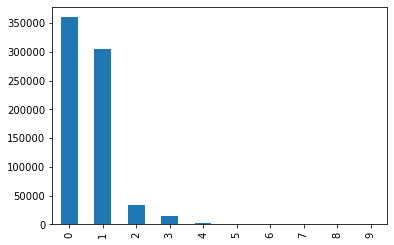

In [86]:
#visualize distribution trainset vs testset
print(y_train.value_counts().sort_index())
print(y_train.value_counts(normalize = True).sort_index())
y_train.value_counts().sort_index().plot(kind='bar');

0    40253
1    33647
2     3799
3     1663
4      328
5      164
6      116
7       29
8        1
dtype: int64
0    0.503162
1    0.420588
2    0.047488
3    0.020788
4    0.004100
5    0.002050
6    0.001450
7    0.000362
8    0.000013
dtype: float64


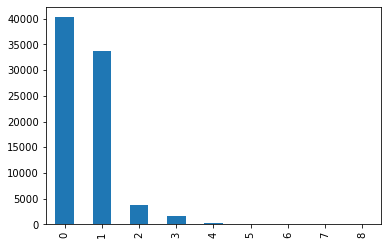

In [87]:
#visualize distribution trainset vs testset -> only 9 classes out of 10
print(y_test.value_counts().sort_index())
print(y_test.value_counts(normalize = True).sort_index())
y_test.value_counts().sort_index().plot(kind='bar');

Due to imbalanced data, not all classes make it to test ds.  Manually add a missing class.  
Todo: implement stratified sampling and oversampling.

In [88]:
#add RoyalFlush to test ds, needed for keras NN to work here
idx_royal_flush  = poker[poker['class'] == 'Royal flush'].index
X.iloc[idx_royal_flush]

#append row to X_test and y_test
X_test = X_test.append(X.iloc[idx_royal_flush])
y_test = y_test.append(pd.Series([9,9]))

print(X_test.shape, y_test.shape)

(80002, 52) (80002,)


0    40253
1    33647
2     3799
3     1663
4      328
5      164
6      116
7       29
8        1
9        2
dtype: int64
0    0.503150
1    0.420577
2    0.047486
3    0.020787
4    0.004100
5    0.002050
6    0.001450
7    0.000362
8    0.000012
9    0.000025
dtype: float64


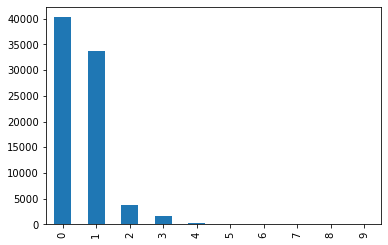

In [89]:
#visualize distribution trainset vs testset -> only 9 classes out of 10
print(y_test.value_counts().sort_index())
print(y_test.value_counts(normalize = True).sort_index())
y_test.value_counts().sort_index().plot(kind='bar');


## 2. Model  

### Logistic Regression

In [90]:
#track time
t0 = time.time()

clf = LogisticRegression(random_state=0, solver='lbfgs',max_iter=100,multi_class='ovr').fit(X_train, y_train)
print ("Training time (in min)", (time.time() - t0)/60)

#predict
y_hat=clf.predict(X_test)
print ("+ Testing time (in min)", (time.time() - t0)/60)

accuracy_score(y_hat,y_test)

Training time (in min) 0.29952415625254314
+ Testing time (in min) 0.30030701955159506


0.5031499212519687

In [91]:
unique, counts = np.unique(y_hat, return_counts=True)
print (np.asarray((unique, counts)).T)

[[    0 80002]]


In [92]:
cm = confusion_matrix(y_test, y_hat)
print("Confusion matrix:\n{}".format(cm))

Confusion matrix:
[[40253     0     0     0     0     0     0     0     0     0]
 [33647     0     0     0     0     0     0     0     0     0]
 [ 3799     0     0     0     0     0     0     0     0     0]
 [ 1663     0     0     0     0     0     0     0     0     0]
 [  328     0     0     0     0     0     0     0     0     0]
 [  164     0     0     0     0     0     0     0     0     0]
 [  116     0     0     0     0     0     0     0     0     0]
 [   29     0     0     0     0     0     0     0     0     0]
 [    1     0     0     0     0     0     0     0     0     0]
 [    2     0     0     0     0     0     0     0     0     0]]


### CART
Classification and Regression Trees or CART for short

In [93]:
#track time
t0 = time.time()

decision_tree = DecisionTreeClassifier(random_state=0,max_depth = 10) #max_depth =2,3
decision_tree = decision_tree.fit(X_train,y_train)
print ("Training time (in min)", (time.time() - t0)/60)

#predict
y_hat = decision_tree.predict(X_test)
print ("+ Testing time (in min)", (time.time() - t0)/60)

accuracy_score(y_hat,y_test)

Training time (in min) 0.10822062889734904
+ Testing time (in min) 0.10898684660593669


0.5886477838054048

In [94]:
unique, counts = np.unique(y_hat, return_counts=True)
print (np.asarray((unique, counts)).T)

[[    0 46708]
 [    1 32923]
 [    2    93]
 [    3   271]
 [    6     3]
 [    7     4]]


In [95]:
cm = confusion_matrix(y_test, y_hat)
print("Confusion matrix:\n{}".format(cm))

Confusion matrix:
[[29012 11241     0     0     0     0     0     0     0     0]
 [15919 17727     1     0     0     0     0     0     0     0]
 [  840  2869    90     0     0     0     0     0     0     0]
 [  526   880     0   257     0     0     0     0     0     0]
 [  269    59     0     0     0     0     0     0     0     0]
 [  123    41     0     0     0     0     0     0     0     0]
 [   13    84     2    14     0     0     3     0     0     0]
 [    5    20     0     0     0     0     0     4     0     0]
 [    1     0     0     0     0     0     0     0     0     0]
 [    0     2     0     0     0     0     0     0     0     0]]


### SVM
We plot each data item as a point in n-dimensional space (where n is number of features you have) with the value of each feature being the value of a particular coordinate

In [96]:
#track time
t0 = time.time()

clf = svm.LinearSVC()
clf.fit(X_train,y_train) 
print ("Training time (in min)", (time.time() - t0)/60)

#predict
y_hat = clf.predict(X_test)
print ("+ Testing time (in min)", (time.time() - t0)/60)

accuracy_score(y_hat,y_test)

Training time (in min) 4.180989988644918
+ Testing time (in min) 4.181869701544444


0.5031499212519687

In [97]:
unique, counts = np.unique(y_hat, return_counts=True)
print (np.asarray((unique, counts)).T)

[[    0 80002]]


In [98]:
cm = confusion_matrix(y_test, y_hat)
print("Confusion matrix:\n{}".format(cm))

Confusion matrix:
[[40253     0     0     0     0     0     0     0     0     0]
 [33647     0     0     0     0     0     0     0     0     0]
 [ 3799     0     0     0     0     0     0     0     0     0]
 [ 1663     0     0     0     0     0     0     0     0     0]
 [  328     0     0     0     0     0     0     0     0     0]
 [  164     0     0     0     0     0     0     0     0     0]
 [  116     0     0     0     0     0     0     0     0     0]
 [   29     0     0     0     0     0     0     0     0     0]
 [    1     0     0     0     0     0     0     0     0     0]
 [    2     0     0     0     0     0     0     0     0     0]]


### Neural Net with Keras
A neural network is a progression of algorithms that attempts to perceive fundamental connections in a lot of information through a procedure that copies the manner in which the human brain works. Neural network can adjust to changing input; so the network produces the most ideal outcome without expecting to redesign the output criteria.
To create NN we used Keras library which is a high-level API wrapper for the low-level API, capable of running on top of TensorFlow, CNTK, or Theano.

This neural network architecture comprised of 3 dense layers with respectively 15,10 and 10 nodes in each layer.

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras import regularizers

In [46]:
#$mycodedelta
#code below errors out: ValueError: Error when checking target: expected dense_3 to have shape (10,) but got array with shape (1,)
#src https://stackoverflow.com/questions/49392972/error-when-checking-target-expected-dense-3-to-have-shape-3-but-got-array-wi/55992428
#issue: problem is with label-data shape
#      Keras expects y-data in (N, 10) shape, not (N,) 
#      was: y_train.shape, y_test.shape
#      was: ((25010,), (1000000,))
#fix: Recode labels using to_categorical to get the correct shape of inputs
from keras.utils import to_categorical
y_train_nn = to_categorical(y_train)
y_test_nn = to_categorical(y_test)

y_train_nn.shape, y_test_nn.shape

((720000, 10), (80002, 10))

In [101]:
model = Sequential()
model.add(Dense(52, activation='relu', input_dim=52))
model.add(Dense(52, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#track time
t0 = time.time()

history = model.fit(X_train, y_train_nn, epochs = 10, batch_size = 256, verbose=1,validation_data=(X_test,y_test_nn),shuffle=True) #$mycodedelta


score = model.evaluate(X_test, y_test_nn, batch_size=256) #$mycodedelta
print ("Training time (in min)", (time.time() - t0)/60)

Train on 720000 samples, validate on 80002 samples
Epoch 1/10
720000/720000 [==============================] - 8s 11us/step - loss: 0.0816 - accuracy: 0.9663 - val_loss: 0.0206 - val_accuracy: 0.9949
Epoch 2/10
720000/720000 [==============================] - 7s 10us/step - loss: 0.0145 - accuracy: 0.9969 - val_loss: 0.0107 - val_accuracy: 0.9980
Epoch 3/10
720000/720000 [==============================] - 7s 10us/step - loss: 0.0082 - accuracy: 0.9985 - val_loss: 0.0070 - val_accuracy: 0.9988
Epoch 4/10
720000/720000 [==============================] - 8s 11us/step - loss: 0.0058 - accuracy: 0.9990 - val_loss: 0.0055 - val_accuracy: 0.9990
Epoch 5/10
720000/720000 [==============================] - 7s 10us/step - loss: 0.0047 - accuracy: 0.9992 - val_loss: 0.0047 - val_accuracy: 0.9992
Epoch 6/10
720000/720000 [==============================] - 7s 9us/step - loss: 0.0042 - accuracy: 0.9993 - val_loss: 0.0047 - val_accuracy: 0.9991
Epoch 7/10
720000/720000 [==============================

In [102]:
score[1]

0.9992390871047974

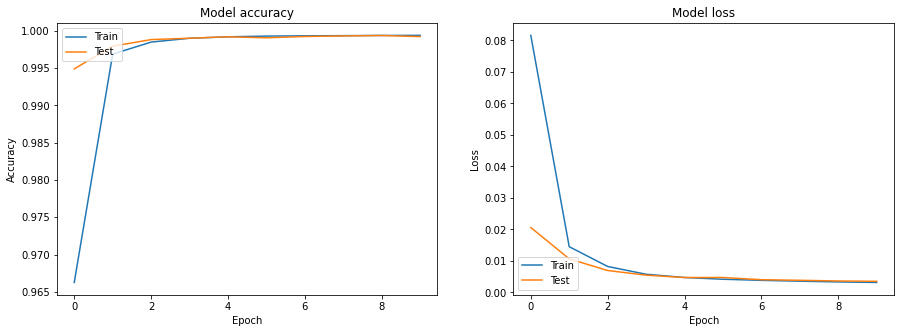

In [103]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy']) #$mycodedelta
plt.plot(history.history['val_accuracy'])#$mycodedelta
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower left')

##### Evaludate NN model
by predicting on the given test set (which unfortunately has been used for validation, too).

In [104]:
#predict
y_hat = model.predict(X_test) #numpy.ndarray
y_hat_class = y_hat.argmax(axis=1)
print ("+ Testing time (in min)", (time.time() - t0)/60)
print(y_hat.shape, y_hat_class.shape)

accuracy_score(y_hat_class, y_test)

+ Testing time (in min) 1.2584459861119588
(80002, 10) (80002,)


0.9961750956226094

In [105]:
unique, counts = np.unique(y_hat_class, return_counts=True)
print (np.asarray((unique, counts)).T)

[[    0 40395]
 [    1 33700]
 [    2  3755]
 [    3  1717]
 [    4   331]
 [    5     5]
 [    6    99]]


In [106]:
cm = confusion_matrix(y_test, y_hat_class)
print("Confusion matrix:\n{}".format(cm))

Confusion matrix:
[[40243     9     0     0     0     1     0     0     0     0]
 [    1 33640     6     0     0     0     0     0     0     0]
 [    0    42  3749     8     0     0     0     0     0     0]
 [    0     0     0  1662     0     0     1     0     0     0]
 [    0     0     0     0   328     0     0     0     0     0]
 [  151     9     0     0     0     4     0     0     0     0]
 [    0     0     0    46     0     0    70     0     0     0]
 [    0     0     0     1     0     0    28     0     0     0]
 [    0     0     0     0     1     0     0     0     0     0]
 [    0     0     0     0     2     0     0     0     0     0]]


A large increase in test accuracy from initial example, where it was ~62%
##### Note
In ML, using the same `test` ds for validation and testing is not a valid technique.  Next step should be to truly have `train`, `validation` and `test` sets and see how all the models fair with a holdout dataset.

Src: https://keras.io/guides/training_with_built_in_methods/
Here's what the typical end-to-end workflow looks like, consisting of:

- Training
- Validation on a holdout set generated from the original training data
- Evaluation on the test data

In [ ]:
#kNN takes a long time to run, run only if needed
mystop

### kNN
try diff values of k = [3,5]

In [63]:
#track time
t0 = time.time()

clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)

print ("Training time (in min)", (time.time() - t0)/60)

#predict
y_hat=clf.predict(X_test)
print ("+ Testing time (in min)", (time.time() - t0)/60)

accuracy_score(y_hat,y_test)

Training time (in min) 0.009761206309000651
+ Testing time (in min) 35.45105593204498


0.7499187520311992

In [64]:
unique, counts = np.unique(y_hat, return_counts=True)
print (np.asarray((unique, counts)).T)

[[    0 44759]
 [    1 32765]
 [    2  1551]
 [    3   802]
 [    4    48]
 [    5    52]
 [    6    20]
 [    7     5]]


In [65]:
cm = confusion_matrix(y_test, y_hat)
print("Confusion matrix:\n{}".format(cm))

Confusion matrix:
[[34746  5479     0     0    14    14     0     0     0     0]
 [ 9634 23499   453    43    12     6     0     0     0     0]
 [    0  2786   997    13     0     0     3     0     0     0]
 [    0   939    31   685     0     0     8     0     0     0]
 [  260    46     0     0    22     0     0     0     0     0]
 [  116    16     0     0     0    32     0     0     0     0]
 [    0     0    70    37     0     0     9     0     0     0]
 [    0     0     0    24     0     0     0     5     0     0]
 [    1     0     0     0     0     0     0     0     0     0]
 [    2     0     0     0     0     0     0     0     0     0]]


In [66]:
#track time
t0 = time.time()

clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)

print ("Training time (in min)", (time.time() - t0)/60)

#predict
y_hat=clf.predict(X_test)
print ("+ Testing time (in min)", (time.time() - t0)/60)

accuracy_score(y_hat,y_test)

Training time (in min) 0.008985388278961181
+ Testing time (in min) 38.22995409170787


0.7847428814279643

In [67]:
unique, counts = np.unique(y_hat, return_counts=True)
print (np.asarray((unique, counts)).T)

[[    0 45328]
 [    1 32982]
 [    2   970]
 [    3   689]
 [    4    13]
 [    5    16]
 [    6     3]
 [    7     1]]


In [68]:
cm = confusion_matrix(y_test, y_hat)
print("Confusion matrix:\n{}".format(cm))

Confusion matrix:
[[36443  3806     0     0     2     2     0     0     0     0]
 [ 8468 25000   152    20     5     2     0     0     0     0]
 [    0  3087   710     2     0     0     0     0     0     0]
 [    0  1029    23   609     0     0     2     0     0     0]
 [  276    46     0     0     6     0     0     0     0     0]
 [  139    14     0     0     0    11     0     0     0     0]
 [    0     0    85    30     0     0     1     0     0     0]
 [    0     0     0    28     0     0     0     1     0     0]
 [    1     0     0     0     0     0     0     0     0     0]
 [    1     0     0     0     0     1     0     0     0     0]]


kNN models trained on transformed Kaggle dataset (800K records in learning set) perform at 74%+ accuracy, which is a great improvement over models trained on non-transformed data.

## 3. Summary
Same data represented differently made a simple algorithm (kNN) way more accurate than a DL model with non-transformed data. So it really matters how you feed the data to ML and which algo you pick. 

Even with improved accuracy, the best algos (kNN and Keras NN) still don't predict the minority classes correctly which means anomaly detection is not successful with either of these algos.  Disclaimer here, didn't perform hyperparamter tuning with any algo.


In [69]:
#only run if need 7 neighbors
mystop

NameError: name 'mystop' is not defined

In [ ]:
mystop

## Xtra

In [ ]:
import scipy.sparse
mat = scipy.sparse.eye(3)
pd.DataFrame.sparse.from_spmatrix(mat)
